In [1]:
import os
os.chdir('/home/nmaruani/ShapeShifter')

In [2]:
from src.diffusion.train_flow_matching import *
import yaml
from IPython.display import clear_output


In [7]:
level=1
model_name="canyon"
with open(f'/home/nmaruani/ShapeShifter/configs/train_diffusion_up.yaml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.Loader)

X, X_UP, X0 = get_gt_data(cfg, level, model_name)
device='cuda'

In [8]:
model_upsampler = torch.load(
            './checkpoints/upsamplers_colors/{}_{}.pt'.format(model_name, level), weights_only=False)

model_upsampler.eval()
with torch.no_grad():
    X0_BLUR = model_upsampler(X, X_UP).detach()
X0_BLUR.grid = X0.grid

In [9]:
L = []
LOSS_EMA = None
model = DiffusionCNN(channels=cfg["features"], layers=cfg["layers"], time_emb=cfg["time_emb"],
                        one_layers=cfg["one_layers"], first_ks=cfg["first_ks"],
                        in_channels=X0.jdata.shape[-1], out_channels=X0.jdata.shape[-1]).to(device)
mt.count_parameters(model)

optimizer = torch.optim.Adam(model.parameters(),
                                lr=cfg["lr"]
                                )

loss_fn = torch.nn.functional.mse_loss
sparse_fm = SparseFlowMatching(
        model,
        timesteps=cfg["diffusion_timesteps"],
        loss=nn.functional.mse_loss,
        model_upsampler=model_upsampler if level > 0 else None,
    ).cuda()

The model has 1.2M parameters


In [11]:
def train_epoch(optimizer, sparse_fm):
        global LOSS_EMA
        optimizer.zero_grad()
        if level > 0:
            loss = sparse_fm(*clip_data(X0, X0_BLUR, cfg["clip_size"]))
        else:
            loss = sparse_fm(X0)
        torch.nn.utils.clip_grad_norm_(sparse_fm.model.parameters(), 1.)
        loss.backward()
        optimizer.step()
        if LOSS_EMA is None:
            LOSS_EMA = loss.item()
        else:
            LOSS_EMA = 0.99 * LOSS_EMA + 0.01 * loss.item()
        L.append(LOSS_EMA)

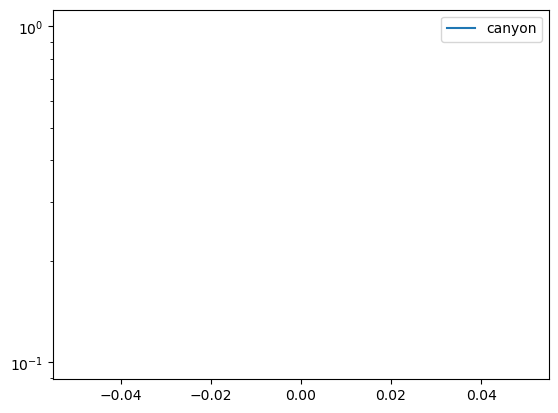

  0%|          | 163/40000 [00:05<23:11, 28.62it/s] 


KeyboardInterrupt: 

In [12]:
model.train()
for i in tqdm(range(cfg["epochs"])):
    train_epoch(optimizer, sparse_fm)
    if i % cfg["save_every"] == 0 or i == cfg["epochs"]-1:
        clear_output(True)
        plt.plot(L, label='canyon')
        plt.yscale('log')
        plt.legend()
        plt.show()
torch.save(model, f'fm_{model_name}_{level}.pt')

### Sampling+

In [ ]:
def p1_to_flow(model, XT, T):
    p1 = model(XT, T)
    p1.feature.jdata = (p1.jdata-XT.jdata)/(1-T[:, None])
    return p1
    
@torch.no_grad()
def model_step(model, XT, t_start, t_end):
    TSTART = t_start.view(1).expand(len(XT.jdata))
    TEND = t_end.view(1).expand(len(XT.jdata))

    p1 = p1_to_flow(model, XT, TSTART)
    p1.feature.jdata *= (TEND-TSTART)[:, None]/2.
    p1.feature.jdata += XT.jdata
    
    
    p2 = p1_to_flow(model, p1, TSTART+ (TEND-TSTART)/2.)
    
    p2.feature.jdata *= (TEND-TSTART)[:, None]
    p2.feature.jdata += XT.jdata
    
    return p2

In [ ]:
i=0
fac = .8
n_steps = 200
time_steps = torch.linspace(0, 1.0, n_steps + 1, device=device)
model = torch.load(f'fm_{model_name}_{level}.pt')
model.eval()
X = fvnn.VDBTensor(grid=X0.grid, feature=X0.grid.jagged_like(torch.randn_like(X0.jdata)))
X.feature.jdata = (fac)*X0_BLUR.jdata + (1-fac)*torch.randn_like(X0.jdata)
X0data = X.jdata.clone()
for i in tqdm(range(n_steps-1)):
    X = model_step(model, X, time_steps[i], time_steps[i+1])
X = model(X, time_steps[-2])

/tmp/ipykernel_2961817/2254865755.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'fm_{model_name}_{level}.pt')
100%|██████████| 200/200 [00:01<00:00

In [8]:
for ind in range(2):
    disp_d = DiffusionTensor(X.grid[ind], X.feature[ind]).remove_mask()
    # disp_d.get_global().colored_PC(.07)

    c=(disp_d.feature.jdata[:, 6:9].cpu().detach().numpy()+2)/4
    plot(*grid_to_mesh(disp_d.grid, colors=c), shading={'wireframe':True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…